# MinHash & LSH Application

* Based on https://medium.com/@bassimfaizal/finding-duplicate-questions-using-datasketch-2ae1f3d8bc5c

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import nltk

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-question-pairs/train.csv.zip
/kaggle/input/quora-question-pairs/test.csv.zip
/kaggle/input/quora-question-pairs/sample_submission.csv.zip
/kaggle/input/quora-question-pairs/test.csv


## Step 1: Data Extraction

In [ ]:
qa_pairs = pd.read_csv('/data/train.csv')

# Step 2: Meet and Greet data

In [ ]:
qa_pairs.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
qa_pairs.sample(10, random_state=42)

,id,qid1,qid2,question1,question2,is_duplicate
8067,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0
368101,368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0
70497,70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0
226567,226567,254474,258192,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1
73186,73186,48103,3062,How close we are to see 3rd world war?,How close is a World War III?,1
215105,215105,177688,83888,What do Chinese people think about Donald Trump?,What do Chinese people think of Donald Trump?,1
253209,253209,367707,153452,How many hours a week do Google employees work?,How many hours a day do Google employees work ...,0
354651,354651,483796,11244,How can we follow a Quora question privately w...,How can we view private Instagram pictures wit...,0
104478,104478,172497,172498,Why are cats so overprotective?,How do you know if your cat is overprotective?,1
163628,163628,254474,254475,How do I improve logical programming skills?,What is the best way to improve logical skills...,1


In [ ]:
qa_pairs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [ ]:
qa_pairs[~qa_pairs['question1'].apply(lambda question: type(question) == str)]

,id,qid1,qid2,question1,question2,is_duplicate
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [ ]:
qa_pairs = qa_pairs.dropna(subset=['question1'])

# Step 3: Univariant Analysis

In [ ]:
qa_pairs['is_duplicate'].value_counts()

0    255026
1    149263
Name: is_duplicate, dtype: int64

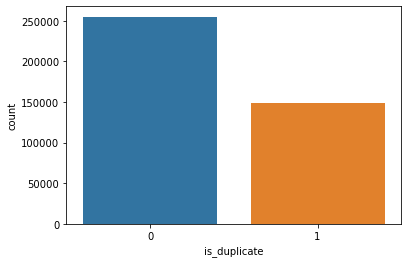

In [ ]:
sns.countplot(qa_pairs['is_duplicate'])

In [ ]:
token_len_q1 = qa_pairs['question1'].apply(lambda question: len(set(question)))

Text(0.5, 0, 'token lenght per question')

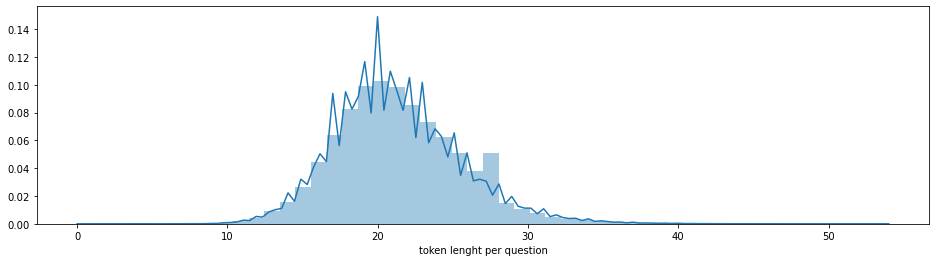

In [ ]:
fig, ax = plt.subplots(figsize=(16,4))
sns.distplot(token_len_q1, ax=ax)
ax.set_xlabel('token lenght per question')

Text(0.5, 0, 'token lenght per question')

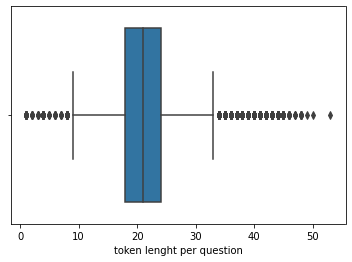

In [ ]:
sns.boxplot(token_len_q1)
plt.xlabel('token lenght per question')

# Step 4: MinHast and LSH 

In [ ]:
pip install datasketch[scipy]

     |████████████████████████████████| 73 kB 385 kB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import datasketch

In [ ]:
qa_pairs.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
sents_pairs = pd.concat([qa_pairs[qa_pairs['is_duplicate'] == 0].sample(100, random_state=42), 
                   qa_pairs[qa_pairs['is_duplicate'] == 1].sample(100, random_state=42)]).reset_index(drop=True).sample(frac=1.)
sents_pairs.shape

(200, 6)

In [ ]:
sents = pd.concat([sents_pairs['question1'], sents_pairs['question2']])
sents.head()

51     What are the best restaurants to try when visi...
190    Why do people ask questions on Quora that coul...
6      What is the algorithm used to reserve ticket i...
92     Can I eat a box of food which is just on the '...
161    How do I self rehab from masturbation and porn...
dtype: object

In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
# Set Representation

'''
set_dict maps question id (eg 'm23') to set representation of questionnorm_dict maps question id (eg 'm23') to actual question.
#May use this dictionary to #evaluate results of LSH output.We loop through each question, convert them into shingles, 
and if the shingle isn’t a stop word,
we add them to a hashset which will be the value for the set_dict dictionary.
'''


set_dict={} 

norm_dict={} 
count=1
for question in tqdm([x for x in sents]):
   temp_list = []
   for shingle in question.split(' '):
       if shingle not in stop_words:
           temp_list.append(shingle.lower())
   set_dict["m{0}".format(count)] = set(temp_list)
   norm_dict["m{0}".format(count)] = question
   count +=1

100%|██████████| 400/400 [00:00<00:00, 20940.37it/s]


In [ ]:
set_dict['m1']

{'best',
 'fl?',
 'jacksonville,',
 'restaurants',
 'there?',
 'try',
 'visiting',
 'what'}

## MinHashing

In [ ]:
# Create minHash signatures

'''
num_perm is the number of permutations we want for the MinHash algorithm (discussed before). 
The higher the permutations the longer the runtime.Min_dict maps question id (eg 'm23') to min hash signatures.
We loop through all the set representations of questions and calculate the signatures and store them in the min_dict dictionary.
'''


num_perm = 256
min_dict = {}
count2 = 1
for val in tqdm(set_dict.values()):
   m = datasketch.MinHash(num_perm=num_perm)
   for shingle in val:
       m.update(shingle.encode('utf8'))
   min_dict["m{}".format(count2)] = m
   count2+=1

100%|██████████| 400/400 [00:01<00:00, 212.74it/s]


MinHash data structure:

In [ ]:
min_dict['m1']

In [ ]:
elem_test = next(iter(set_dict['m1']))
elem_test

'there?'

Are two minhash structures the same despite being initialized as different objects?

In [ ]:
m1 = datasketch.MinHash(num_perm=num_perm)
m1.update(elem_test.encode('utf8'))
m2 = datasketch.MinHash(num_perm=num_perm)
m2.update(elem_test.encode('utf8'))

In [ ]:
m1 == m2

True

In [ ]:
m1.jaccard(m2)

1.0

Yes.

Get hash values:

In [ ]:
first_digest = m1.digest()
first_digest.shape

(256,)

In [ ]:
first_digest

array([1582924685, 2708566761,  571904805, 3608209369, 3638975527,
        441695820, 2408609655,  891149720, 3354884990, 2907194007,
       3747109254, 1239203893,  778686136, 1592138593, 1737053865,
       3887678884,  463723865, 1072246230, 4199307457, 3401260980,
       1181248579, 1045583440, 1851203496, 1120847440, 1560435290,
        119528473,  691571151,  845485581, 3547060152,  289131135,
        632914953,   60977328, 4054050627, 4170057156, 1131104483,
       2403183735, 2284801833, 2964883561, 2556577899, 2862698638,
       3350992868, 1210105868,   12408073, 1814943029,  726178401,
       1368949215, 1731806131, 3763622382, 2493302005, 3624773502,
       2603695649, 1624793182, 2466881132, 3876855139, 3848700777,
       2595148015, 1956028260, 3538942445, 1732390064, 2246875808,
       3221930183, 1898362556, 3013352169, 1836312426, 2579475177,
       1025432845, 2417036328, 3359688139, 2203108349,  583875652,
       2787445452, 1463884744, 1633710775, 3461600509, 4232541

In [ ]:
iter_text = iter(set_dict['m1'])
next(iter_text)
elem_test2 = next(iter_text)
elem_test2

'visiting'

In [ ]:
m1.update(elem_test2.encode('utf8'))

internal hash values have updated based on new shingle added.

In [ ]:
(m1.digest() == first_digest).all()

False

In [ ]:
list(set_dict['m1']

{'best',
 'fl?',
 'jacksonville,',
 'restaurants',
 'there?',
 'try',
 'visiting',
 'what'}

## LSH

In [ ]:
# Create LSH index

'''
We set the Jaccard similarity threshold as a parameter in MinHashLSH. 
We loop through the signatures or keys in the min_dict dictionary and store them as bands (as described in the theory section of the article). 
Datasketch stores these in a dictionary format, where the key is a question and the values are all the questions deemed similar based on the threshold. 
But we need them in candidate pairs as they are much easier to evaluate, so we use a function called create_cand_pairs 
which simply changes the format of the dictionary to be a list of lists with each sub-list being a candidate pair.
'''

lsh = datasketch.MinHashLSH(threshold=0.4, num_perm=num_perm)
for key in tqdm(min_dict.keys()):
   lsh.insert(key,min_dict[key]) # insert minhash data structure

100%|██████████| 400/400 [00:00<00:00, 1239.68it/s]


lsh.query: Giving the MinHash of the query set, retrieve the keys (m1, m2 etc.) that references sets with approximate! Jaccard similarities greater than the threshold.

In [ ]:
big_list = []
for query in min_dict.keys():
   big_list.append(lsh.query(min_dict[query]))
 

In [ ]:
big_list[0]

['m1']

In [ ]:
big_list[5]

['m206', 'm6']

In [ ]:
norm_dict[big_list[5][0]], norm_dict[big_list[5][1]]

("How do I dress in the mid to late 80's gym gear that carried over into the year 1990 if I'm a guy?",
 "How would I dress in the mid to late 80's gym wear that carried over into the year 1990 if I'm a guy?")